In [0]:
import os
import itertools
import codecs
import re
import datetime
import editdistance
import numpy as np
import pylab
import random
from itertools import cycle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imageio import imread, imwrite
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive
import pickle

In [2]:
images = []
labels = []
numbers = []
labels_dict = {}
local = False
if local:
  folder = 'out/'
else:
  drive.mount('/content/gdrive')
  folder = '/content/gdrive/My Drive/University/tfg/dataset/'

with open(folder + "labels.txt") as labelsfile: 
  for line in labelsfile:
    number, label = line.split(": ")
    labels_dict[number] = label.strip()
    
for filename in os.listdir(folder):
  if not "png" in filename: continue
  images.append(Image.open(folder + filename).convert('L'))
  number = filename.split(".")[0]
  labels.append(labels_dict[number])
  numbers.append(number)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
i = 0
len(images)

1415

crop_47_10: (q38,B)=(q39,1,R)


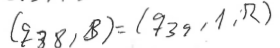

In [4]:
i = np.random.randint(0,len(images))
print(numbers[i], labels[i], sep=": ")
images[i]

In [5]:
print(labels[:5])

['(q26,0)=(q27,0,R)', '(q26,Z)=(q26,Z,R)', '(q17,1)=(q17,Z,R)', '(q24,1)=(q24,1,L)', '(q24,Y)=(q24,Y,L)']


In [6]:
# Get average height and width of images
heights, widths = 0,0
for image in images:
  heights += image.height
  widths += image.width
height, width = heights // len(images), widths // len(images)
height, width

(38, 192)

In [0]:
# Resize images
height, width = 30, 170
res_images = []
for image in images:
  res_images.append(image.resize((width, height), Image.ANTIALIAS))

In [8]:
# View some:
res_images[random.randint(0,len(images)-1)]

In [9]:
# Construct the alphabet
alphabet = set()
for label in labels:
  for char in label:
    alphabet.add(char)
char_to_ix = dict()
ix_to_char = dict()
for ix,char in enumerate(sorted(alphabet)):
  char_to_ix[char] = ix
  ix_to_char[ix] = char
print(*sorted(alphabet))

  ( ) + , 0 1 2 3 4 5 6 7 8 9 = A B C D E F L O R X Y Z d l q r


In [0]:
# Save alphabet
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
with open(folder + 'alphabet.pickle', 'wb') as handle:
  pickle.dump(alphabet, handle)
with open(folder + 'ixchar.pickle', 'wb') as handle:
  pickle.dump(ix_to_char, handle)

In [0]:
# TODO: Load parameters from project source
# Data Parameters 
img_h = height
img_w = width
input_shape = (img_w, img_h, 1)
max_string_len = max([len(label) for label in labels])

# Network parameters
conv_filters = 32
num_convs = 2
kernel_size = (3,3)
pool_size = 2
time_dense_size = 64
ctc_cut = 2
ctc_input_length = (img_w // (pool_size ** num_convs)) - ctc_cut
ctc_input_length = np.expand_dims(np.array([ctc_input_length] * len(images)), 1)
output_size = len(alphabet) + 1
act = 'relu'

In [12]:
# A tensor where all values are the same, is required by ctc loss
ctc_input_length.shape

(1415, 1)

In [0]:
# Need to transpose all images
t_images = []
for image in res_images:
    t_images.append(np.expand_dims(np.array(image).T, 2))
t_images = np.array(t_images, dtype=np.float32) / 255.0

In [0]:
# Need to create an array of label lengths
label_lens = []
for label in labels:
    label_lens.append(len(label))
label_lens = np.expand_dims(np.array(label_lens), 1)

In [0]:
# Need to encode the labels
e_labels = np.full([len(images), max_string_len], len(alphabet))
for i,label in enumerate(labels):
    enc = []
    for char in label:
        enc.append(char_to_ix[char])
    e_labels[i][:len(enc)] = enc

In [0]:
def label_to_text(ixes):
    ret = []
    for c in ixes:
        if c == len(alphabet) or c == -1:  # CTC Blank
            ret.append("")
        else:
            ret.append(ix_to_char[c])
    return "".join(ret)

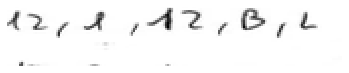

The label is:  12,1,12,B,L
Should match:  [11] 11


In [17]:
# Explore the data, check that everything is correct
i = random.randint(0, len(t_images)-1)
plt.imshow(np.squeeze(t_images[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(e_labels[i]))
print("Should match: ", label_lens[i], len(label_to_text(e_labels[i])))

In [0]:
# Save numpy arrays
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
np.save(folder + "t_images.npy", t_images)
np.save(folder + "e_labels.npy", e_labels)
np.save(folder + "label_lens.npy", label_lens)

In [0]:
# Encode the synthetic number dataset labels with the alphabet
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
batch1x = np.load(folder + "batch1x.npy")
batch2x = np.load(folder + "batch2x.npy")
batch3x = np.load(folder + "batch3x.npy")
batch1y = np.load(folder + "batch1y.npy")
batch2y = np.load(folder + "batch2y.npy")
batch3y = np.load(folder + "batch3y.npy")
batch1ye = np.full([len(batch1y), max_string_len], len(alphabet))
batch2ye = np.full([len(batch2y), max_string_len], len(alphabet))
batch3ye = np.full([len(batch3y), max_string_len], len(alphabet))
batch1ylen = np.zeros((len(batch1y),1))
batch2ylen = np.zeros((len(batch2y),1))
batch3ylen = np.zeros((len(batch3y),1))

# Encoding loop
for batch, batch_e in zip([batch1y, batch2y, batch3y], [batch1ye, batch2ye, batch3ye]):
  for i,label in enumerate(batch):
    enc = []
    for char in label:
        enc.append(char_to_ix[char])
    batch_e[i][:len(enc)] = enc
    
# Label lengths loop
for batch, batchlen in zip([batch1y, batch2y, batch3y], [batch1ylen, batch2ylen, batch3ylen]):
  for i,label in enumerate(batch):
    batchlen[i] = len(label)  

In [20]:
batch3y.shape

(167,)

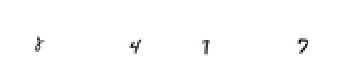

The encoded label is:  8477
The source  label is:  8477
Should match:  [4.] 4


In [21]:
# Explore the data, check that everything is correct
i = random.randint(0, len(batch1x)-1)
plt.imshow(np.squeeze(batch1x[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The encoded label is: ", label_to_text(batch1ye[i]))
print("The source  label is: ", batch1y[i])
print("Should match: ", batch1ylen[i], len(label_to_text(batch1ye[i])))

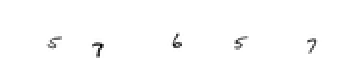

The label is:  57657
Should match:  [5.] 5


In [22]:
# Explore the data, check that everything is correct
i = random.randint(0, len(batch2x)-1)
plt.imshow(np.squeeze(batch2x[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(batch2ye[i]))
print("Should match: ", batch2ylen[i], len(label_to_text(batch2ye[i])))

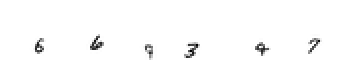

The label is:  667347
Should match:  [6.] 6


In [23]:
# Explore the data, check that everything is correct
i = random.randint(0, len(batch3x)-1)
plt.imshow(np.squeeze(batch3x[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(batch3ye[i]))
print("Should match: ", batch3ylen[i], len(label_to_text(batch3ye[i])))

In [0]:
# Save numpy arrays
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
batchx = np.concatenate([batch1x, batch2x, batch3x], axis=0) / 255
batchye = np.concatenate([batch1ye, batch2ye, batch3ye], axis=0)
batchylen = np.concatenate([batch1ylen, batch2ylen, batch3ylen], axis=0)
# Add channel dim to images
batchx = np.expand_dims(batchx, axis=3)
np.save(folder + "batchx.npy", batchx)
np.save(folder + "batchye.npy", batchye)
np.save(folder + "batchylen.npy", batchylen)